# Colima Seperate GS Inversion

In [34]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display(raw_df.head())

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
16,VF00-04a,1499,1506,625.80,60,19.0,31.0,18.0,11.0,6.0,2.0,1.0,1.0,1.0,2124.861643
18,VF00-06a3,1957,1997,417.20,40,7.0,30.0,25.0,17.0,11.0,5.0,1.0,1.0,1.0,2796.043276
17,VF00-05a3,1787,2173,500.64,48,10.0,30.0,24.0,16.0,9.0,3.0,1.0,1.0,1.0,2813.413940
37,VF06-03/5-09,-770,3082,594.51,57,11.0,25.0,25.0,19.0,11.0,4.0,1.0,1.0,1.0,3176.731654
31,VF05-08a3,-1673,3152,125.16,12,10.0,22.0,24.0,16.0,10.0,4.0,2.0,1.0,1.0,3568.477687


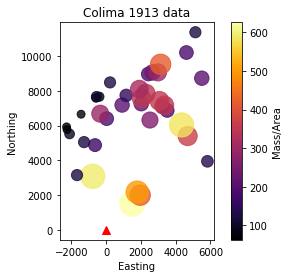

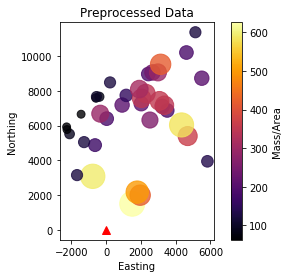

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values*100

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,0,732.730,23.15290,25.4668,22.2407,15.7304,8.99492,3.44384,0.823464,0.136596,0.010359,2124.861643,117.086929
18,1957,1997,0,691.154,21.35410,24.7682,22.4602,16.5434,9.82586,3.90198,0.968656,0.164832,0.012894,2796.043276,165.664909
17,1787,2173,0,709.841,21.21370,24.7100,22.4801,16.6062,9.88889,3.93999,0.980849,0.167220,0.013114,2813.413940,141.786713
37,-770,3082,0,301.066,13.80220,19.2173,22.1297,20.4626,14.72470,7.12663,2.105690,0.398324,0.032906,3176.731654,50.641032
31,-1673,3152,0,149.680,9.51561,14.8613,20.3208,22.2637,18.49420,10.31720,3.459940,0.706562,0.060698,3568.477687,119.590924


In [5]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]*100

display(t2_const_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,2500,1394.460,17.2005,24.2121,24.7779,18.9162,10.8457,3.58293,0.449327,0.015328,0.000028,2124.861643,222.828380
18,1957,1997,2500,1216.150,14.0160,22.3619,24.8640,20.2838,12.7356,4.93885,0.769130,0.030705,0.000063,2796.043276,291.502876
17,1787,2173,2500,1251.000,13.8770,22.2837,24.8861,20.3522,12.8046,4.98427,0.780754,0.031310,0.000064,2813.413940,249.880153
37,-770,3082,2500,359.399,14.8025,22.8299,24.5313,19.4545,12.2828,5.13528,0.922533,0.041096,0.000091,3176.731654,60.452978
31,-1673,3152,2500,134.301,15.3664,23.3283,24.4813,18.8191,11.7036,5.16746,1.079070,0.054478,0.000132,3568.477687,107.303452


In [6]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,1024.0,"[-5,-4)",-5.0,0.068338,-4.0
1,-3.5,1024.0,"[-4,-3)",-4.0,0.109203,-3.0
2,-2.5,1024.0,"[-3,-2)",-3.0,0.146694,-2.0
3,-1.5,1024.0,"[-2,-1)",-2.0,0.165650,-1.0
4,-0.5,1024.0,"[-1,0)",-1.0,0.157243,0.0
5,0.5,1233.5,"[0,1)",0.0,0.125474,1.0
6,1.5,1443.0,"[1,2)",1.0,0.084166,2.0
7,2.5,1652.5,"[2,3)",2.0,0.047459,3.0
8,3.5,1862.0,"[3,4)",3.0,0.022496,4.0


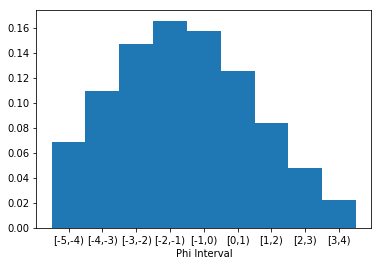

In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [8]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values*100
display(forward_df.head())

Forward Sim time: 0.04688 seconds
Dataframe Merge time: 0.03125 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.01562 seconds
Total time: 0.09375 seconds


,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,17.023654,24.058691,24.746126,19.010648,10.986457,3.680616,0.476505,0.017266,0.000036,1316.804462,2124.861643,210.419377
1,1997,1957,13.849036,22.187896,24.802962,20.364657,12.884741,5.062941,0.813217,0.034469,0.000080,1148.987823,2796.043276,275.404560
2,2173,1787,13.800371,22.209864,24.864958,20.379976,12.855621,5.043105,0.811521,0.034502,0.000081,1166.987337,2813.413940,233.099101
3,3082,-770,15.561092,23.674710,24.901902,19.059630,11.448421,4.522511,0.794749,0.036892,0.000093,300.904559,3176.731654,50.613877
4,3152,-1673,16.255639,24.321103,24.942842,18.429623,10.768184,4.367639,0.869463,0.045380,0.000126,111.014810,3568.477687,88.698314


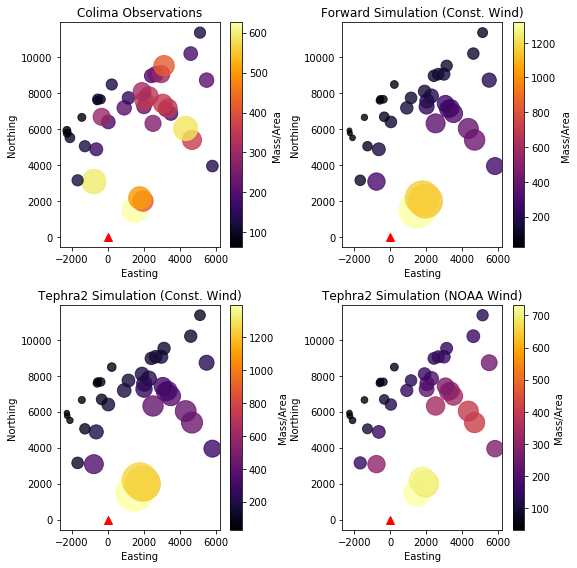

c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


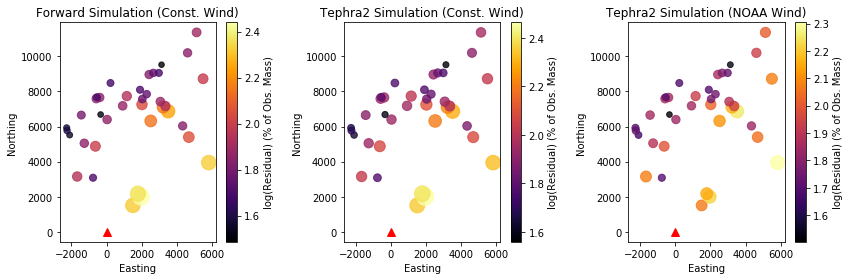

In [9]:
fig, axs = plt.subplots(2,2, figsize=(
        8,8), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[3])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
            title="Forward Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[2])




plt.tight_layout()
plt.show()

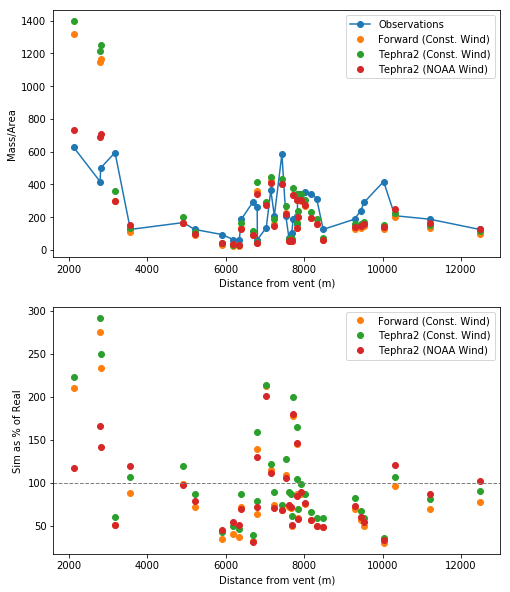

In [10]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========[-5,-4)========
a* = 4.49284	b* = 4.40848	            h1* = -0.13862	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 8.77307	TM* = 22.04730
a = 90.37456	b = 83.14430	            h1 = 9511.58727	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 3758564623.12040
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 335
SSE: 3.9471441642635963


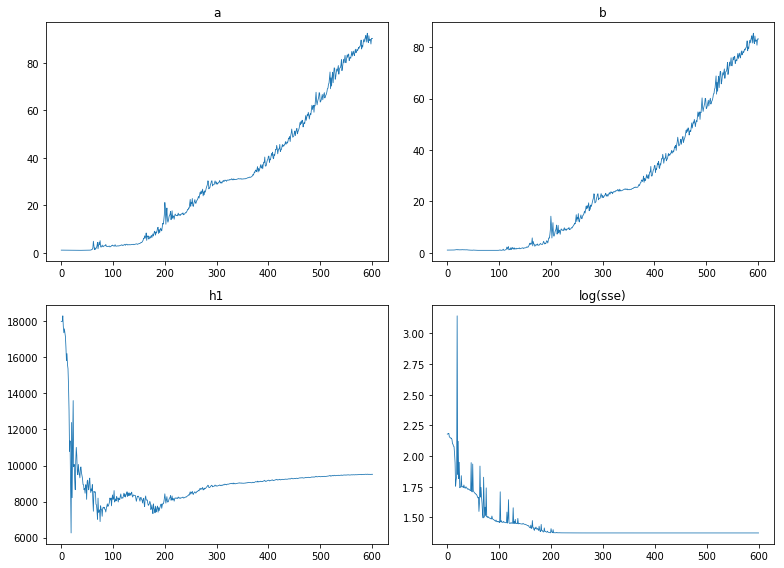

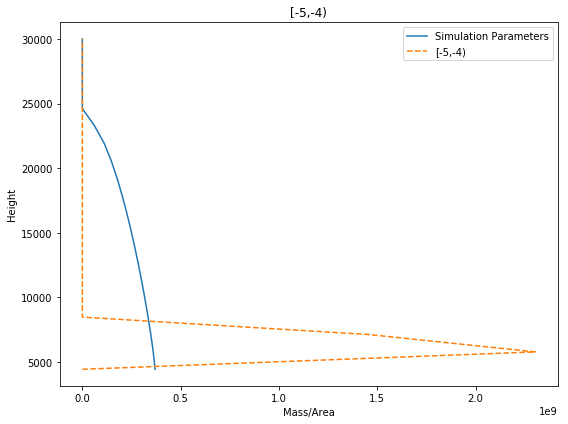

[-5,-4) Run Time: 0.11719 minutes


========[-4,-3)========
a* = 4.80690	b* = 3.98294	            h1* = -0.09717	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 8.77307	TM* = 22.51605
a = 123.35154	b = 54.67475	            h1 = 9965.71974	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 6006169166.09182
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 340
SSE: 20.361429496057756


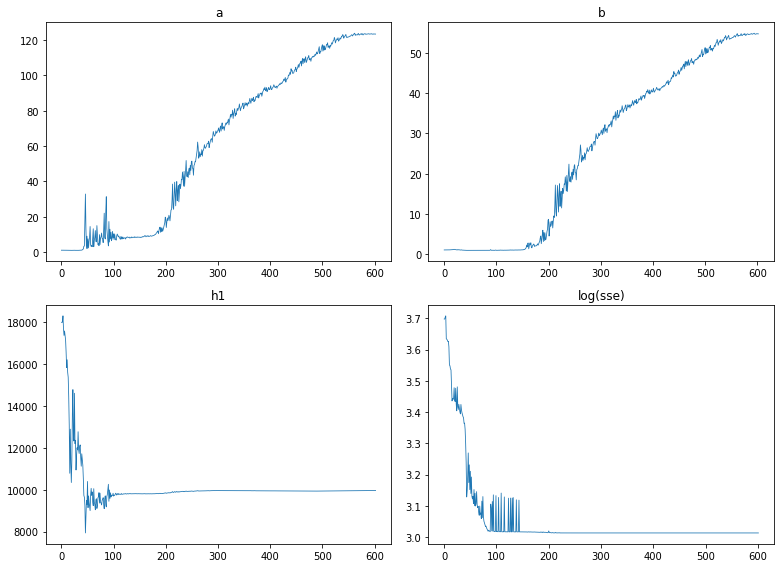

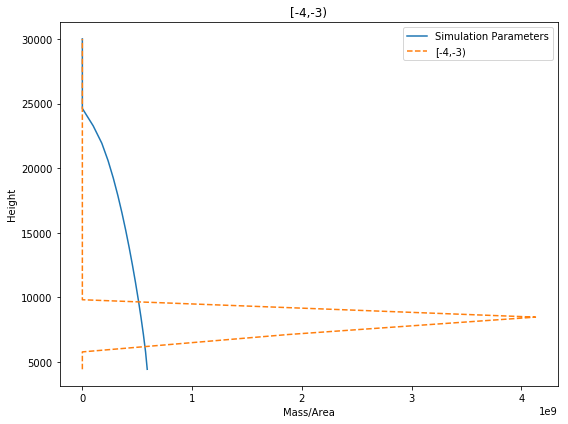

[-4,-3) Run Time: 0.11901 minutes


========[-3,-2)========
a* = 0.42742	b* = -0.06015	            h1* = 1.62070	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 8.77307	TM* = 22.81119
a = 2.53329	b = 1.94162	            h1 = 24616.99627	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 8068164622.31213
Success: True, Optimization terminated successfully.
Iterations: 309
SSE: 20.422402790721144


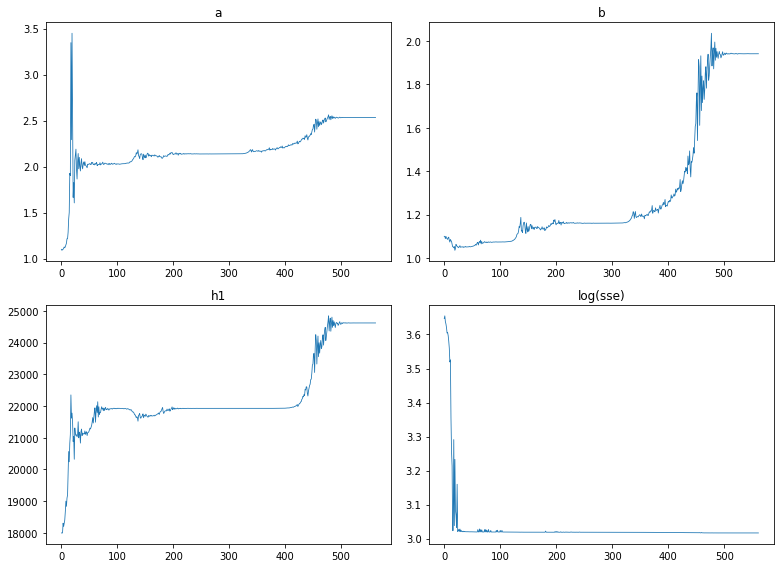

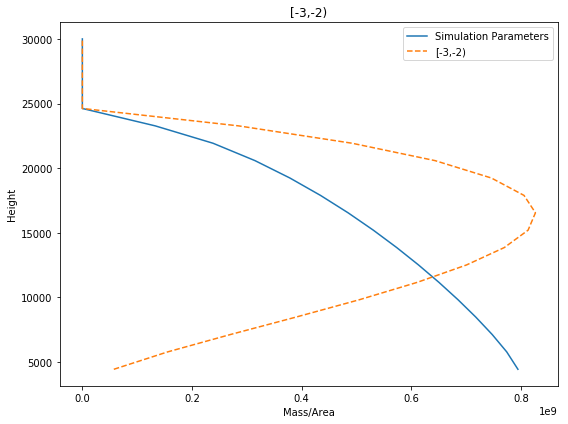

[-3,-2) Run Time: 0.11042 minutes


========[-2,-1)========
a* = -0.20003	b* = -1.85125	            h1* = 2.26955	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 8.77307	TM* = 22.93272
a = 1.81871	b = 1.15704	            h1 = 27054.09144	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 9110738766.61036
Success: True, Optimization terminated successfully.
Iterations: 177
SSE: 13.738112381307841


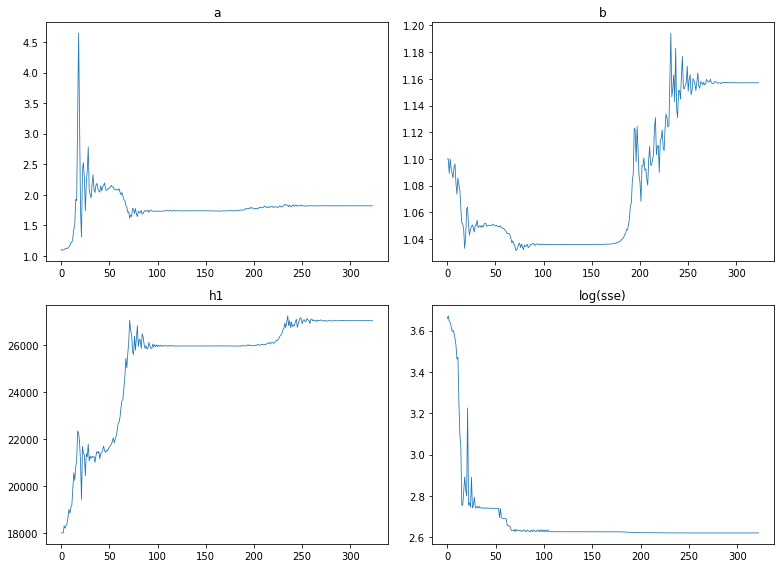

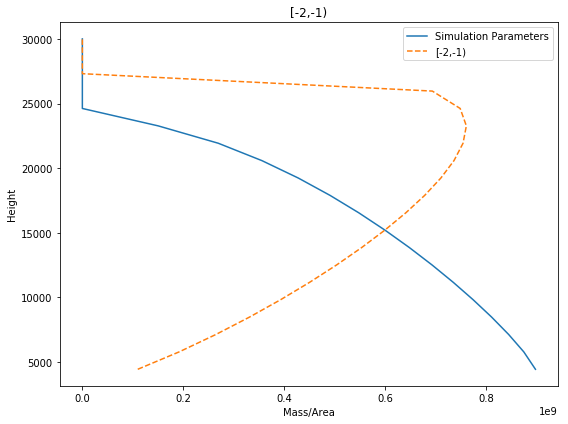

[-2,-1) Run Time: 0.06797 minutes


========[-1,0)========
a* = 6.16953	b* = 5.65987	            h1* = 0.80832	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 8.77307	TM* = 22.88064
a = 478.96255	b = 288.11141	            h1 = 19213.06778	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 8648366582.16271
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 342
SSE: 13.718560108771548


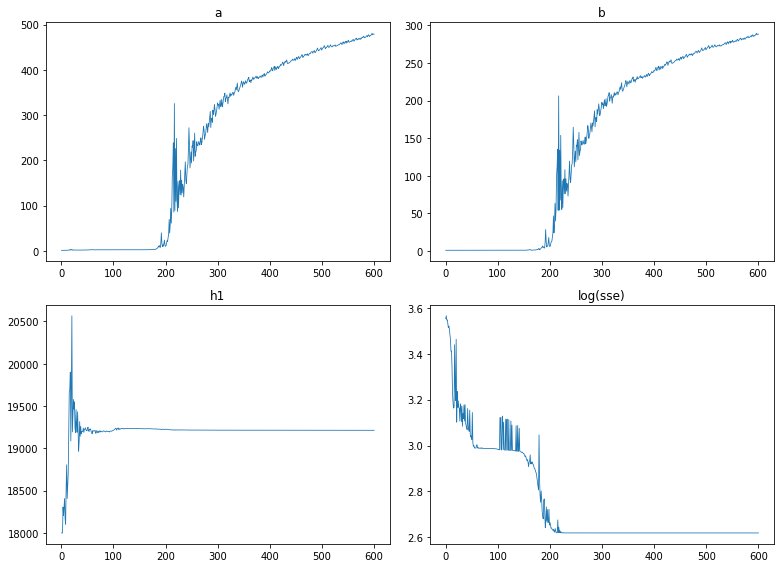

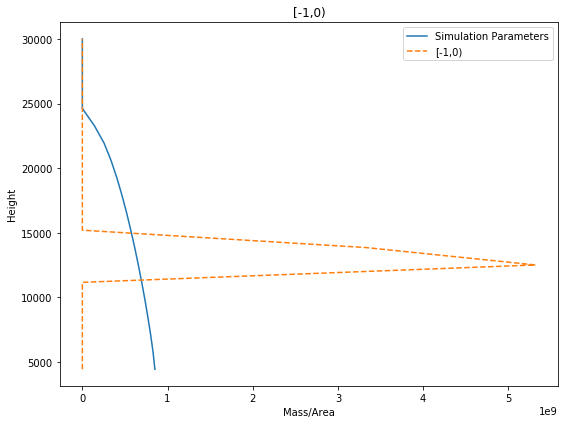

[-1,0) Run Time: 0.11563 minutes


========[0,1)========
a* = 0.86924	b* = -5.32430	            h1* = 0.01116	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 8.77307	TM* = 22.65494
a = 3.38509	b = 1.00487	            h1 = 11159.50000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 6901066909.64173
Success: True, Optimization terminated successfully.
Iterations: 245
SSE: 9.276084746627678


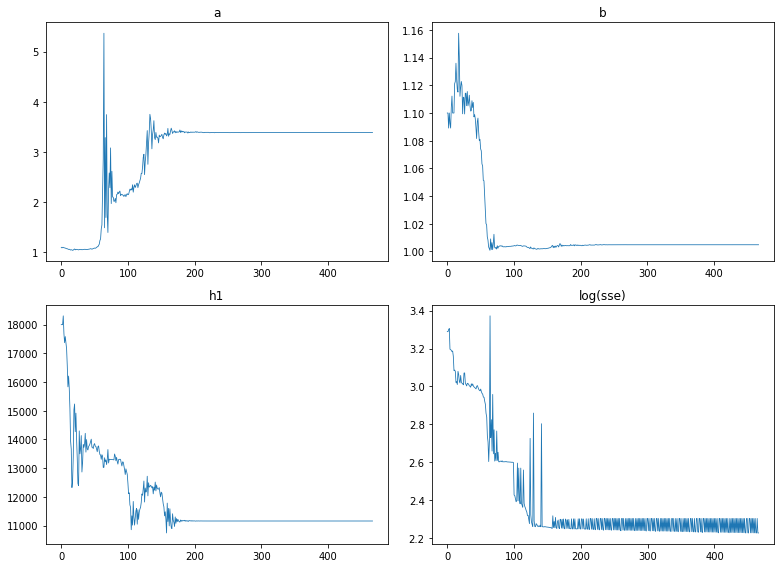

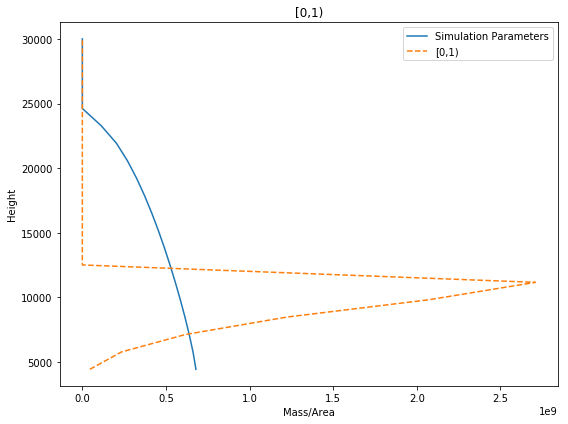

[0,1) Run Time: 0.09349 minutes


========[1,2)========
a* = 4.72163	b* = 4.79684	            h1* = 0.19589	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 8.77307	TM* = 22.25564
a = 113.35118	b = 122.12712	            h1 = 13185.15566	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 4629137051.12431
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 340
SSE: 0.6179328171273498


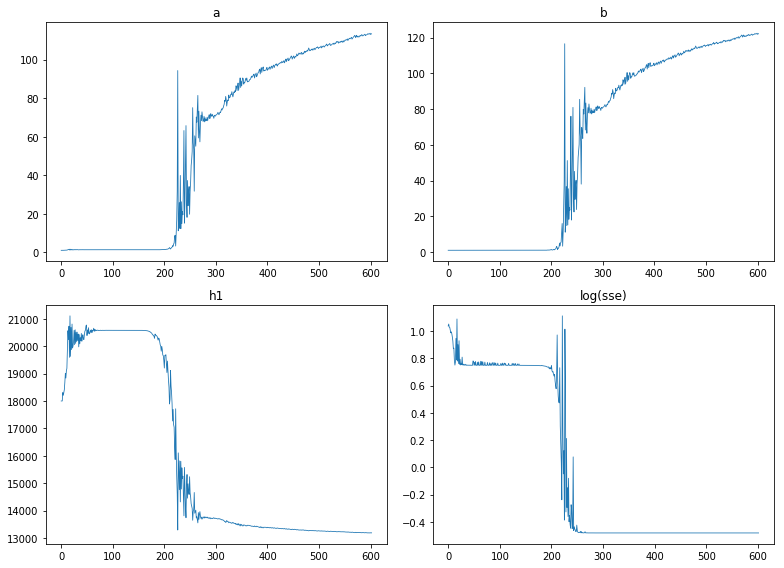

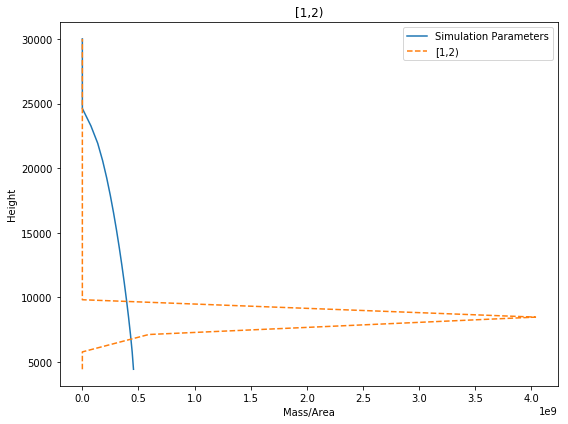

[1,2) Run Time: 0.11823 minutes


========[2,3)========
a* = -0.88199	b* = 0.02470	            h1* = 1.45189	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 8.77307	TM* = 21.68272
a = 1.41396	b = 2.02501	            h1 = 23737.82748	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 2610270359.57395
Success: True, Optimization terminated successfully.
Iterations: 243
SSE: 0.6285131220034958


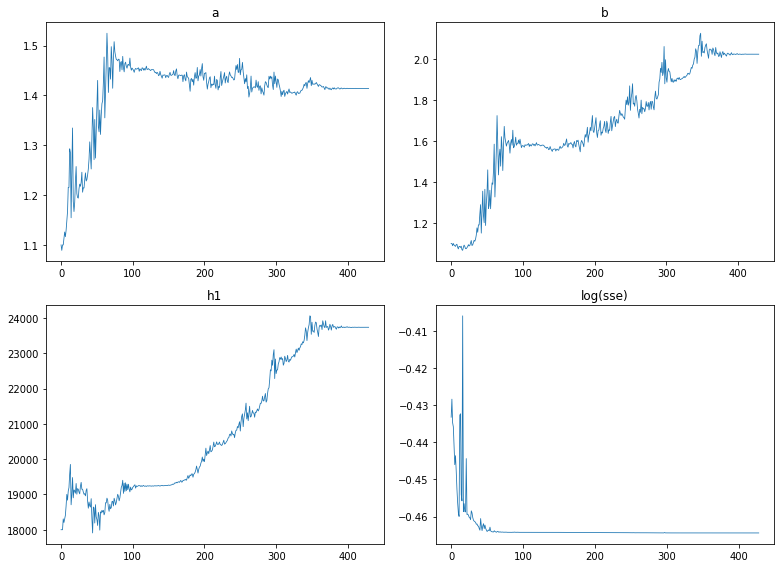

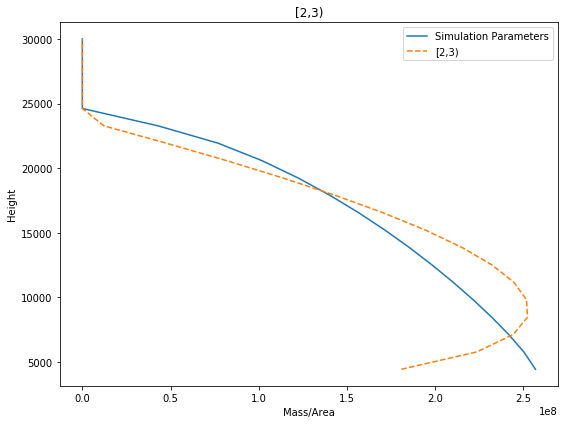

[2,3) Run Time: 0.08542 minutes


========[3,4)========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:430: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = 31.05050	b* = -19.41701	            h1* = -0.64848	u* = 1.73414	v* = 2.10915	            D* = 8.29804	ftt* = 8.77307	TM* = 20.93619
a = 30553464211043.44531	b = 1.00000	            h1 = 4430.75000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 1237293118.15410
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 318
SSE: 3.9987758314301423


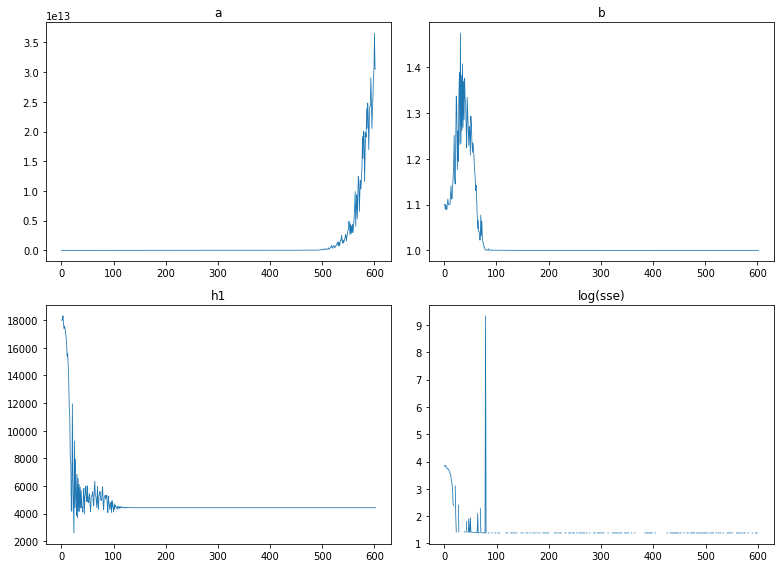

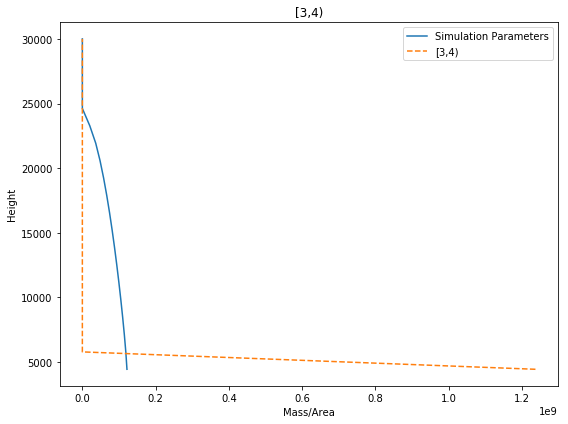

[3,4) Run Time: 0.11458 minutes


Total Run Time: 0.94193 minutes


In [29]:
df = obs_df


priors_vals = {
    "a": 1.1,
    "b": 1.1,
    "h1": 18000,
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": False,
    "v": False,
    "D": False,
    "ftt": False,
    "M": False
}


H = 30000

wind_angle = np.radians(55.5)


t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []


for phi_step in phi_steps:
    t = process_time()
    
    phi_df = df.copy()
    
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    
    priors_vals["M"] = mass_in_phi
    
    print("========%s========"%phi_step["interval"])
    
    out = gaussian_stack_inversion(
        phi_df, len(phi_df), 20, config["VENT_ELEVATION"], 
        H, 2500, [phi_step],
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
#     display(inversion_table)
    plume_trace = np.array(plume_trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    
    plt.tight_layout()
    plt.show()
     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                mass_in_phi)

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

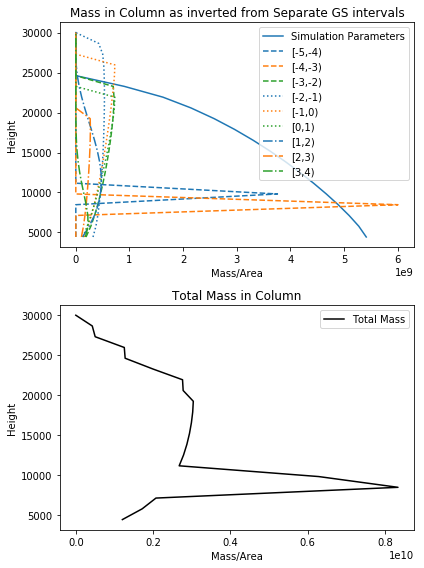

In [27]:
fig, axs = plt.subplots(2,1, figsize=(
    6, 8), facecolor='w', edgecolor='k')
ax1, ax2 = axs.ravel()
    
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

linestyles = ["C0--","C1--","C2--","C0:","C1:","C2:","C0-.","C1-.","C2-."]

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
totmass = np.zeros(len(inverted_masses_list[0]))
    
for i, (phi_step, mass) in enumerate(zip(phi_steps, inverted_masses_list)):
    totmass += mass
    ax1.plot(mass, 
         inversion_table["Height"], 
         linestyles[i], label=phi_step["interval"])
    
ax2.plot(totmass, inversion_table["Height"], "k-", label="Total Mass")
ax1.legend()
ax2.legend()

ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.set_title("Total Mass in Column")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

========[-5,-4)========
a* = 0.16002	b* = 0.44049	            h1* = -0.23619	u* = 2.11205	v* = 2.83223	            D* = -209.07267	ftt* = 8.69951	TM* = 22.04730
a = 2.17353	b = 2.55347	            h1 = 8455.20289	u = 8.26517	v = 16.98331	            D = 0.00000	ftt = 6000.00000	TM = 3758564623.12040
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 787
SSE: 2.9574567222182115


,Height,Suspended Mass
0,"4,430.75",1.31844e+09
1,"5,776.5",1.58016e+09
2,"7,122.25",8.5996e+08
3,"8,468",0
4,"9,813.75",0
5,"11,159.5",0
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


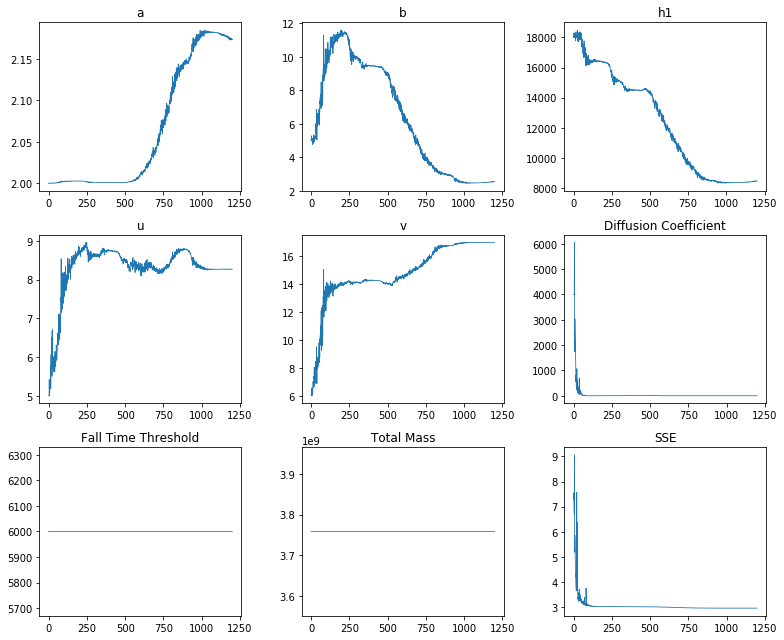

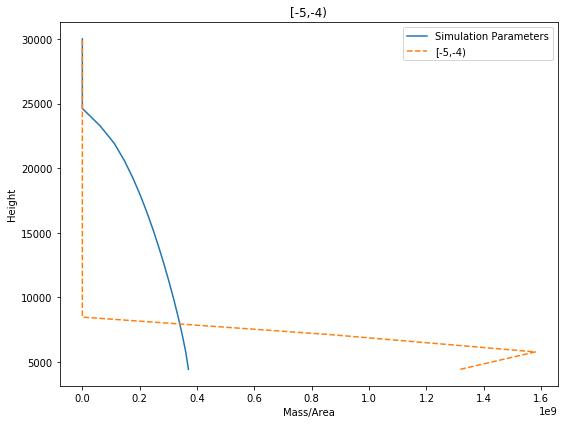

[-5,-4) Run Time: 0.26302 minutes


========[-4,-3)========
a* = 0.02591	b* = -3.54192	            h1* = -0.37691	u* = 0.81027	v* = 3.24550	            D* = 8.36710	ftt* = 8.69951	TM* = 22.51605
a = 2.02625	b = 1.02896	            h1 = 6982.63763	u = 2.24851	v = 25.67445	            D = 4303.12124	ftt = 6000.00000	TM = 6006169166.09182
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 772
SSE: 14.150612120693314


,Height,Suspended Mass
0,"4,430.75",2.00674e+09
1,"5,776.5",3.99943e+09
2,"7,122.25",0
3,"8,468",0
4,"9,813.75",0
5,"11,159.5",0
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


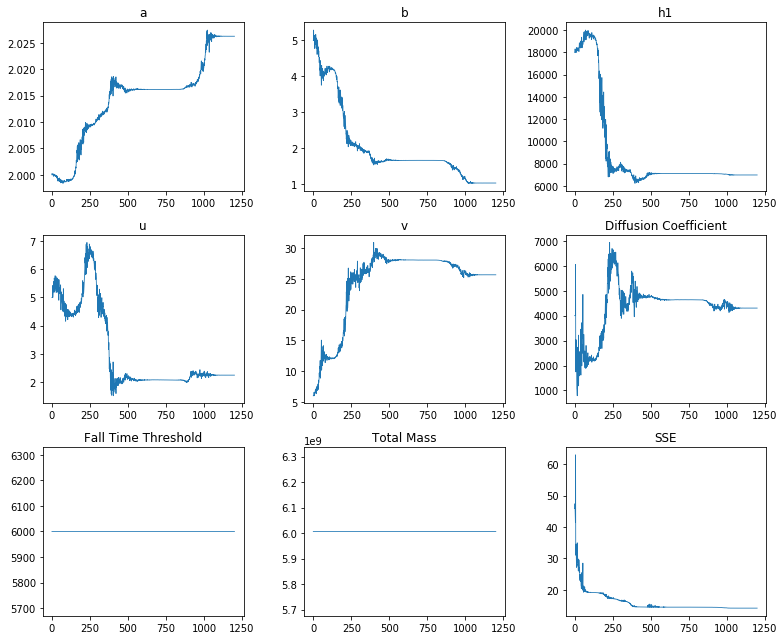

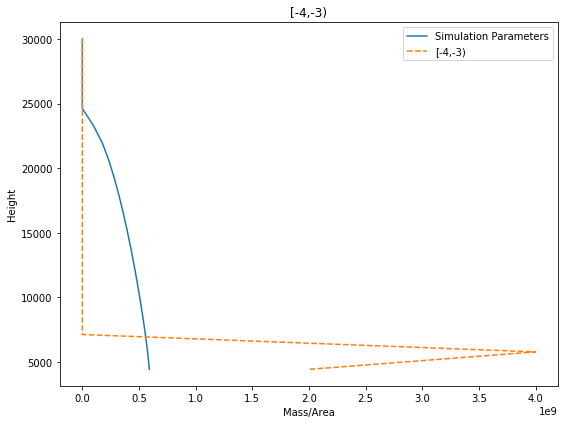

[-4,-3) Run Time: 0.26458 minutes


========[-3,-2)========
a* = -0.00720	b* = 0.59141	            h1* = -0.10420	u* = 2.33114	v* = 3.30918	            D* = 9.44532	ftt* = 8.69951	TM* = 22.81119
a = 1.99282	b = 2.80653	            h1 = 9888.51289	u = 10.28970	v = 27.36258	            D = 12648.82081	ftt = 6000.00000	TM = 8068164622.31213
Success: True, Optimization terminated successfully.
Iterations: 525
SSE: 16.711182554957166


,Height,Suspended Mass
0,"4,430.75",2.36218e+09
1,"5,776.5",2.81871e+09
2,"7,122.25",2.05998e+09
3,"8,468",8.22259e+08
4,"9,813.75",5.02463e+06
5,"11,159.5",0
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


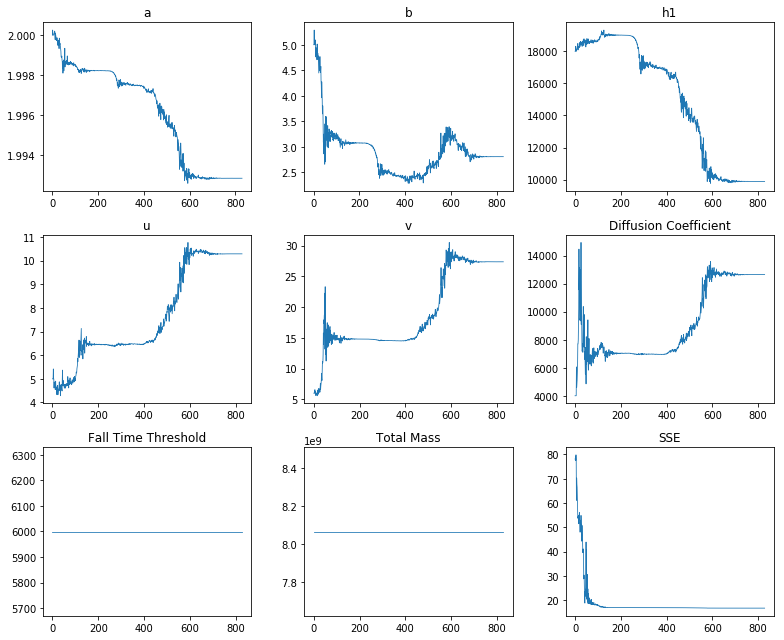

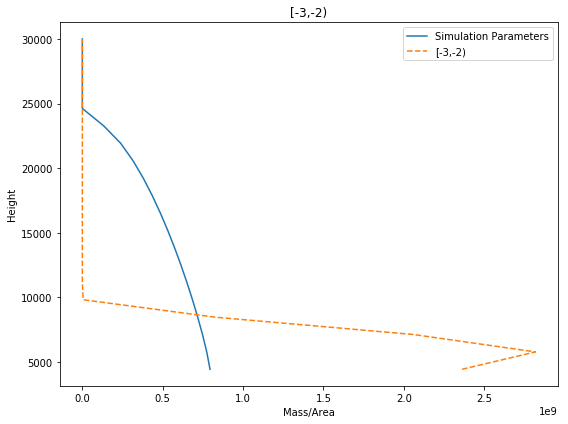

[-3,-2) Run Time: 0.18516 minutes


========[-2,-1)========
a* = -0.00207	b* = -0.48305	            h1* = -0.08656	u* = 2.30575	v* = 3.07353	            D* = 9.53004	ftt* = 8.69951	TM* = 22.93272
a = 1.99794	b = 1.61690	            h1 = 10082.27049	u = 10.03167	v = 21.61805	            D = 13767.18020	ftt = 6000.00000	TM = 9110738766.61036
Success: True, Optimization terminated successfully.
Iterations: 700
SSE: 10.952007152625384


,Height,Suspended Mass
0,"4,430.75",1.24819e+09
1,"5,776.5",2.10778e+09
2,"7,122.25",2.50697e+09
3,"8,468",2.29821e+09
4,"9,813.75",9.49593e+08
5,"11,159.5",0
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


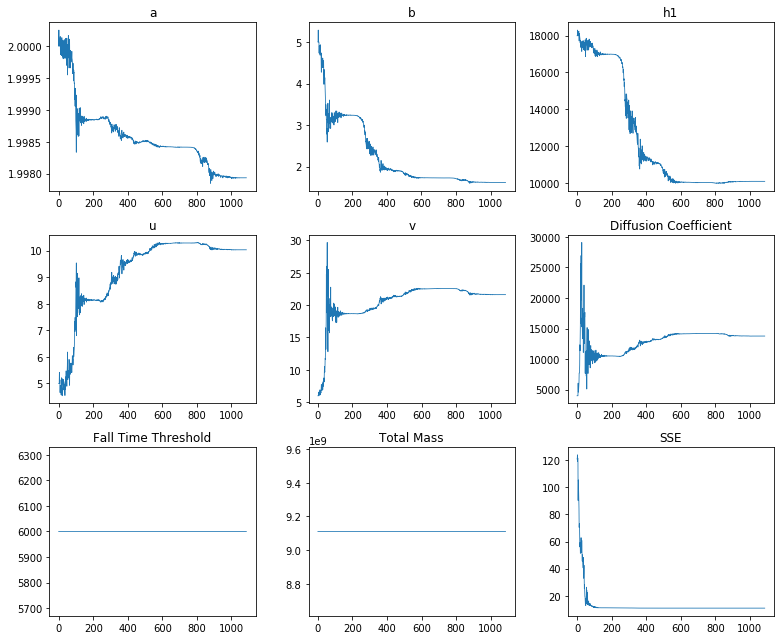

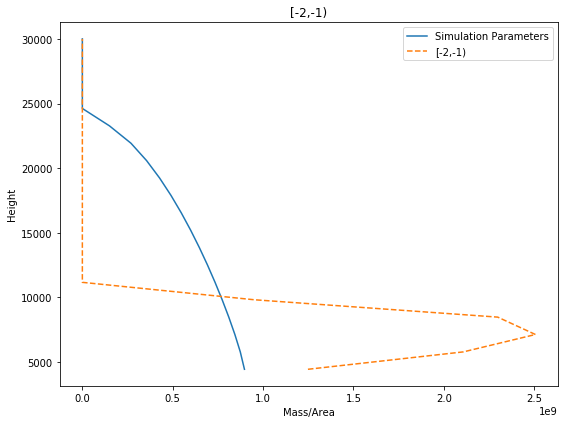

[-2,-1) Run Time: 0.23281 minutes


========[-1,0)========
a* = 0.00346	b* = -3.65135	            h1* = 0.65961	u* = 1.38528	v* = 2.32816	            D* = 8.32200	ftt* = 8.69951	TM* = 22.88064
a = 2.00346	b = 1.02596	            h1 = 17888.24987	u = 3.99596	v = 10.25905	            D = 4113.36804	ftt = 6000.00000	TM = 8648366582.16271
Success: True, Optimization terminated successfully.
Iterations: 554
SSE: 9.842131347127351


,Height,Suspended Mass
0,"4,430.75",1.60895e+08
1,"5,776.5",3.21683e+08
2,"7,122.25",4.81727e+08
3,"8,468",6.40719e+08
4,"9,813.75",7.98317e+08
5,"11,159.5",9.54059e+08
6,"12,505.2",1.10723e+09
7,"13,851",1.25658e+09
8,"15,196.8",1.39942e+09
9,"16,542.5",1.52774e+09


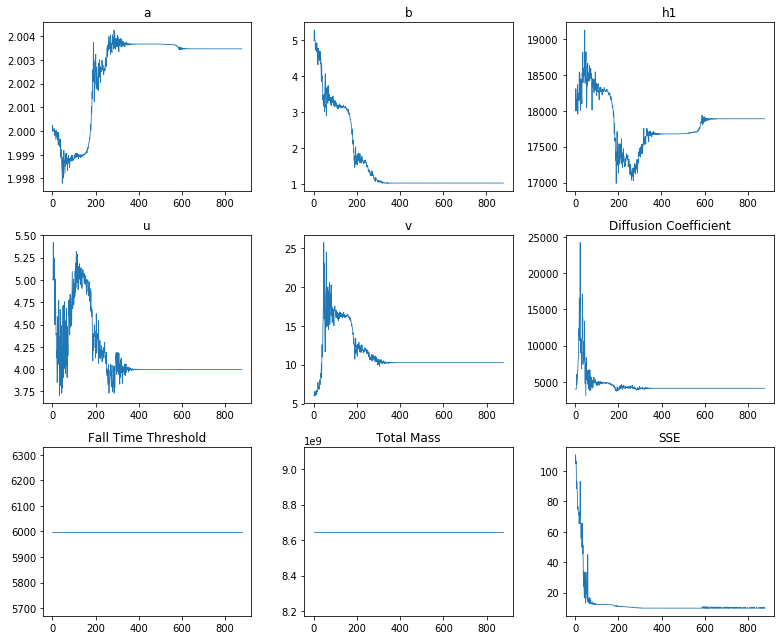

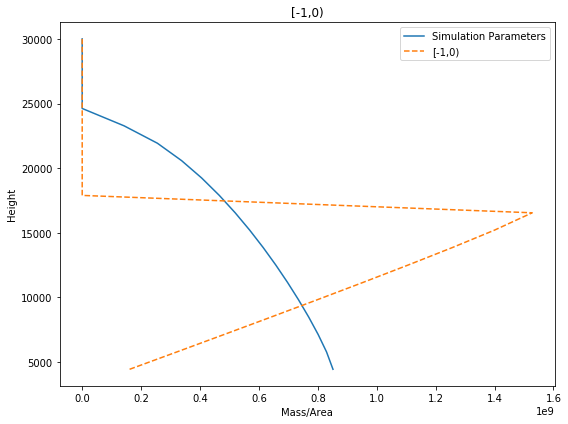

[-1,0) Run Time: 0.19687 minutes


========[0,1)========
a* = 0.02237	b* = -3.50935	            h1* = -0.23493	u* = 1.50635	v* = 2.82817	            D* = 8.36237	ftt* = 8.69951	TM* = 22.65494
a = 2.02262	b = 1.02992	            h1 = 8468.70615	u = 4.51025	v = 16.91442	            D = 4282.81840	ftt = 6000.00000	TM = 6901066909.64173
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 788
SSE: 5.046449896350787


,Height,Suspended Mass
0,"4,430.75",7.52618e+08
1,"5,776.5",1.51059e+09
2,"7,122.25",2.23985e+09
3,"8,468",2.398e+09
4,"9,813.75",0
5,"11,159.5",0
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


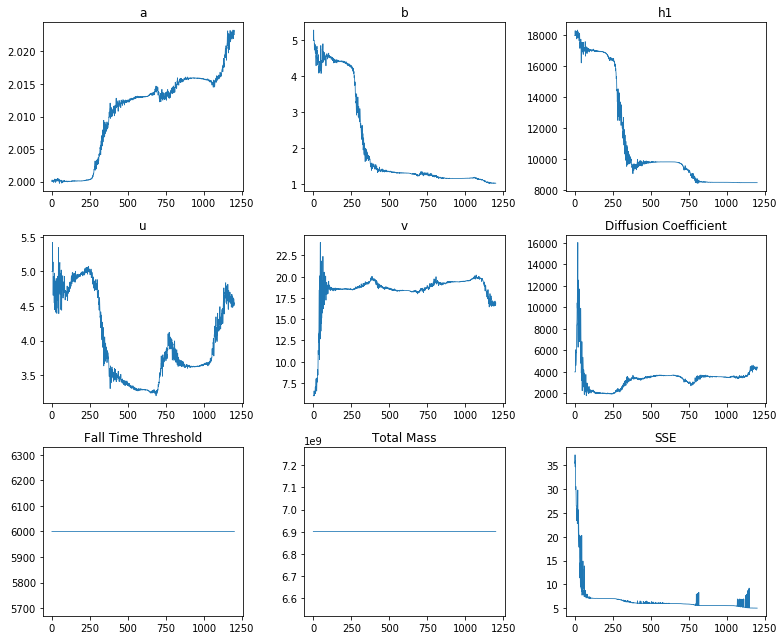

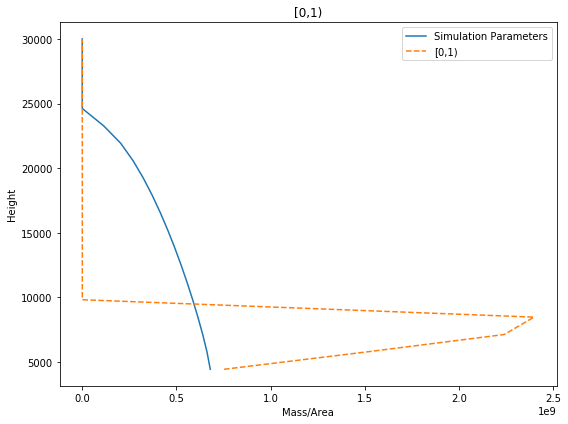

[0,1) Run Time: 0.25964 minutes


========[1,2)========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:430: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = 0.02471	b* = 6.62728	            h1* = -0.55863	u* = 0.19682	v* = 3.62662	            D* = 9.58293	ftt* = 8.69951	TM* = 22.25564
a = 2.02502	b = 756.42699	            h1 = 5222.24563	u = 1.21753	v = 37.58553	            D = 14514.86511	ftt = 6000.00000	TM = 4629137051.12431
Success: True, Optimization terminated successfully.
Iterations: 735
SSE: 0.5078493642588318


,Height,Suspended Mass
0,"4,430.75",4.62914e+09
1,"5,776.5",0
2,"7,122.25",0
3,"8,468",0
4,"9,813.75",0
5,"11,159.5",0
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


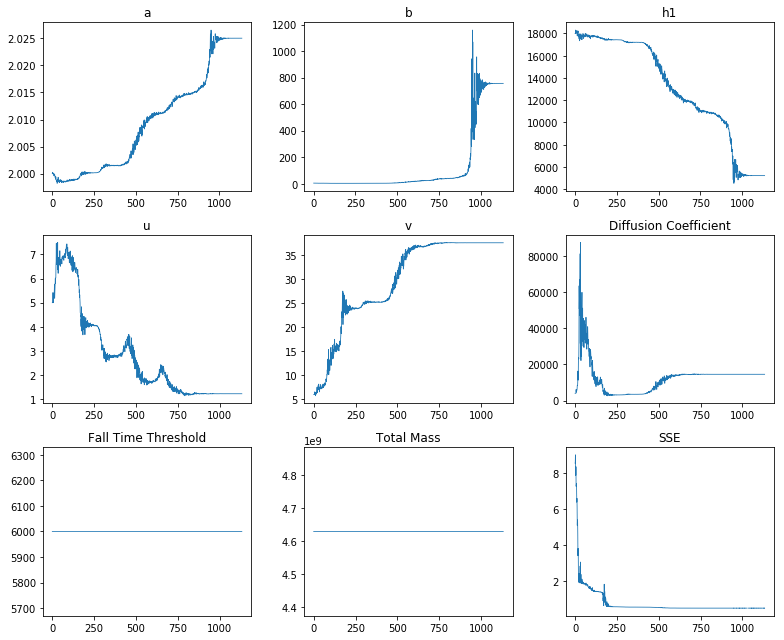

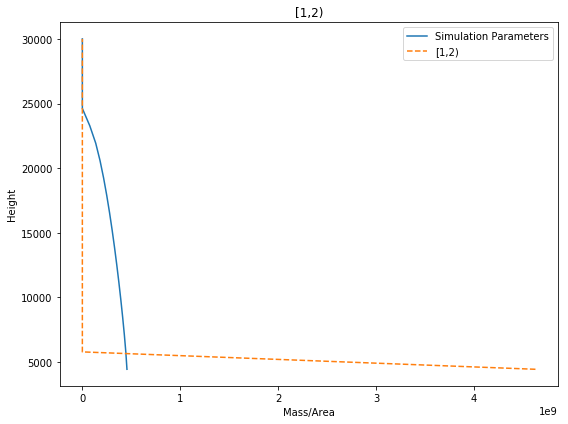

[1,2) Run Time: 0.23542 minutes


========[2,3)========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:694: RuntimeWarning: divide by zero encountered in double_scalars
  wind_speed = u/np.sin(wind_angle)
C:\Users\nmostert\Documents\repos\inversion_project\utils.py:699: RuntimeWarning: invalid value encountered in double_scalars
  v_wind_adj = np.sin(wind_angle)*windspeed_adj


a* = -0.23973	b* = 9.15834	            h1* = 1.00536	u* = -55.28264	v* = -18.99926	            D* = 11.85459	ftt* = 8.69951	TM* = 21.68272
a = 1.78684	b = 9494.24916	            h1 = 20806.89401	u = 0.00000	v = 0.00000	            D = 140728.78112	ftt = 6000.00000	TM = 2610270359.57395
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 738
SSE: 0.310130523502891


,Height,Suspended Mass
0,"4,430.75",2.61027e+09
1,"5,776.5",0
2,"7,122.25",0
3,"8,468",0
4,"9,813.75",0
5,"11,159.5",0
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


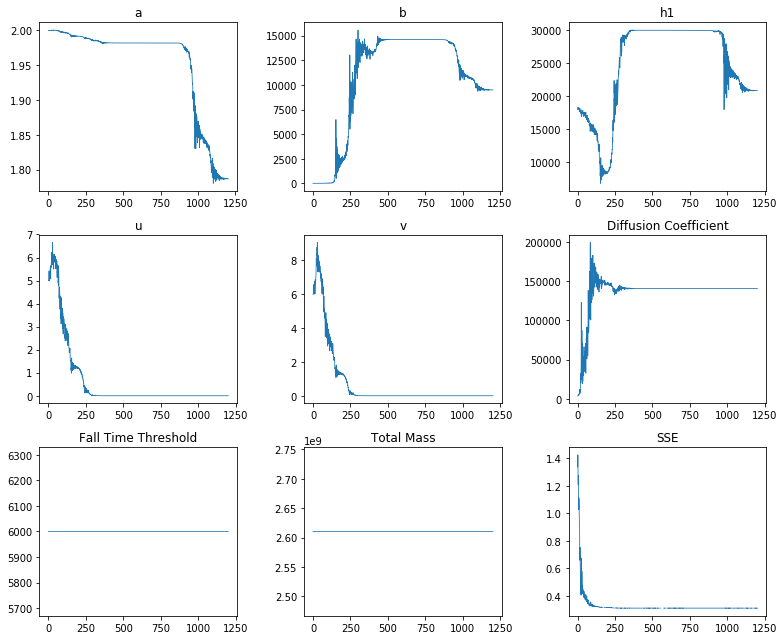

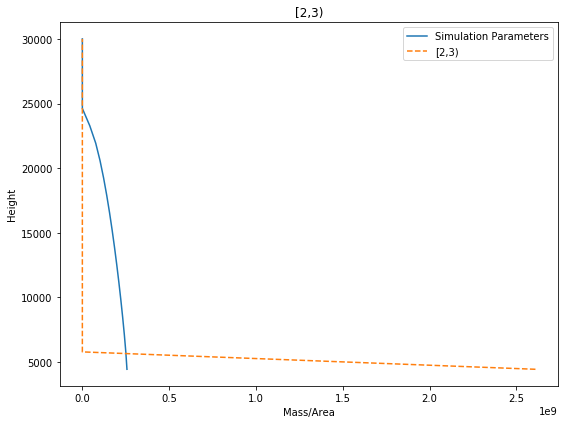

[2,3) Run Time: 0.24635 minutes


========[3,4)========
a* = 0.06939	b* = 8.72034	            h1* = 0.34210	u* = -21.18729	v* = -29.77200	            D* = 9.24381	ftt* = 8.69951	TM* = 20.93619
a = 2.07186	b = 6127.28968	            h1 = 14745.20870	u = 0.00000	v = 0.00000	            D = 10340.39697	ftt = 6000.00000	TM = 1237293118.15410
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 755
SSE: 0.24864372735508958


,Height,Suspended Mass
0,"4,430.75",1.23729e+09
1,"5,776.5",0
2,"7,122.25",0
3,"8,468",0
4,"9,813.75",0
5,"11,159.5",0
6,"12,505.2",0
7,"13,851",0
8,"15,196.8",0
9,"16,542.5",0


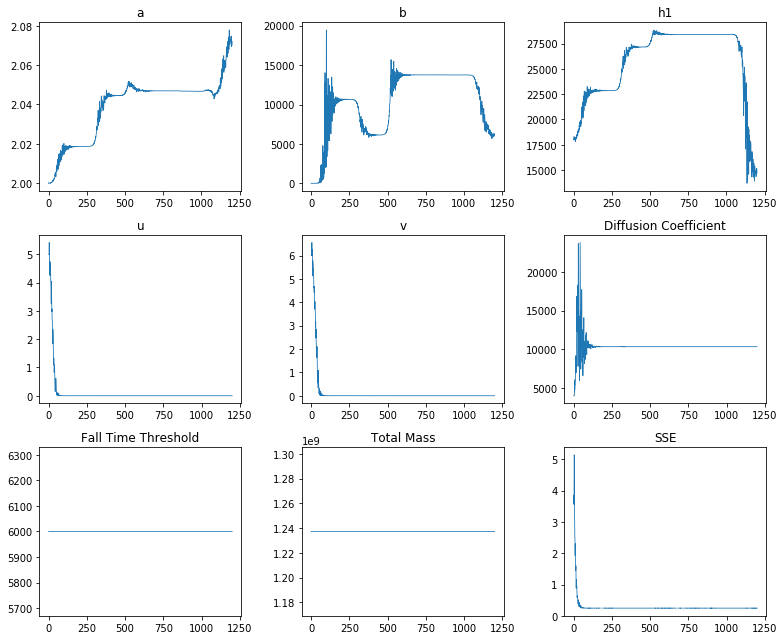

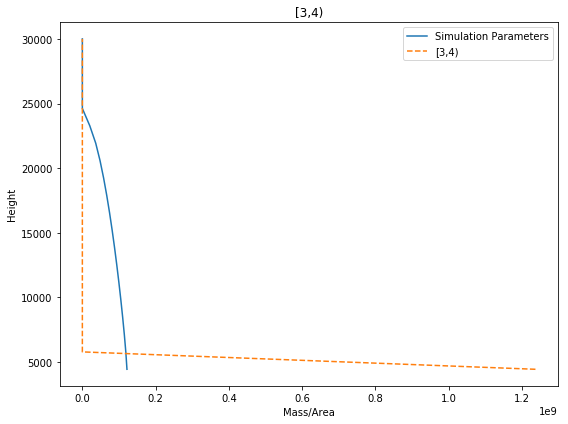

[3,4) Run Time: 0.23333 minutes


Total Run Time: 2.11719 minutes


In [38]:
df = obs_df


priors_vals = {
    "a": 2,
    "b": 5,
    "h1": 18000,
    "u": 5,
    "v": 6,
    "D": 4000,
    "ftt": 6000,
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True,
    "D": True,
    "ftt": False,
    "M": False
}


H = 30000

wind_angle = np.radians(55.5)


t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []


for phi_step in phi_steps:
    t = process_time()
    
    phi_df = df.copy()
    
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    
    priors_vals["M"] = mass_in_phi
    
    print("========%s========"%phi_step["interval"])
    
    out = gaussian_stack_inversion(
        phi_df, len(phi_df), 20, config["VENT_ELEVATION"], 
        H, 2500, [phi_step],
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                mass_in_phi)

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

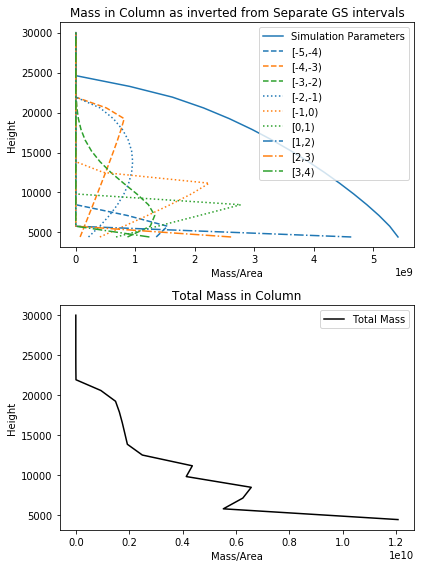

,Dataset,a,b,h1,u,v,D,ftt,M
0,"[-5,-4)",2.03208,2.44433,"8,477.91",8.2528,16.9774,1.132e-17,1.57374e+11,3.75856e+09
1,"[-4,-3)",2.00378,1.0309,"20,579.8",2.29161,6.45163,238.231,1.36284e+26,6.00617e+09
2,"[-3,-2)",2.0007,6.6142,"28,160.6",6.73264,14.4211,"9,086.22",487.012,8.06816e+09
3,"[-2,-1)",1.9975,1.7456,"21,925.5",5.65101,10.758,"6,976.17","39,427.8",9.11074e+09
4,"[-1,0)",2.01635,1.06031,"12,505.3",5.21239,14.5325,"5,875.46","2,003.2",8.64837e+09
5,"[0,1)",2.02762,1.00956,"9,813.75",4.46107,16.2571,"4,293.48",7.66365e+10,6.90107e+09
6,"[1,2)",1.90252,"10,812.4","23,153.1",1.21753,37.5855,"14,514.9","2,226.63",4.62914e+09
7,"[2,3)",2.09046,"12,542.4","26,229.9",2.42579e-07,8.00434e-19,"140,729",2.35121e+74,2.61027e+09
8,"[3,4)",1.98466,"12,796.3","26,692.3",8.66503e-09,1.88805e-08,"10,340.4",1.16414e+33,1.23729e+09


In [37]:
fig, axs = plt.subplots(2,1, figsize=(
    6, 8), facecolor='w', edgecolor='k')
ax1, ax2 = axs.ravel()
    
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

linestyles = ["C0--","C1--","C2--","C0:","C1:","C2:","C0-.","C1-.","C2-."]

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
totmass = np.zeros(len(inverted_masses_list[0]))
    
for i, (phi_step, mass) in enumerate(zip(phi_steps, inverted_masses_list)):
    totmass += mass
    ax1.plot(mass, 
         inversion_table["Height"], 
         linestyles[i], label=phi_step["interval"])
    
ax2.plot(totmass, inversion_table["Height"], "k-", label="Total Mass")
ax1.legend()
ax2.legend()

ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.set_title("Total Mass in Column")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

params_df = pd.DataFrame(params_list)
params_df["Dataset"] = [phi_step["interval"] for phi_step in phi_steps]
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

Now, why is the column shape not preserved? We are assuming a well mixed plume, but that does not appear to be the case here, since each phi class inverts with a different phi. 


In [ ]:
df = obs_df


priors_vals = {
    "a": 2,
    "b": 5,
    "h1": 18000,
    "u": 5,
    "v": 6,
    "D": 4000,
    "ftt": 6000,
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True,
    "D": True,
    "ftt": False,
    "M": False
}


H = 30000

wind_angle = np.radians(55.5)


t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []


for phi_step in phi_steps:
    t = process_time()
    
    phi_df = df.copy()
    
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    
    priors_vals["M"] = mass_in_phi
    
    print("========%s========"%phi_step["interval"])
    
    out = gaussian_stack_inversion(
        phi_df, len(phi_df), 20, config["VENT_ELEVATION"], 
        H, 2500, [phi_step],
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = inversion_table["Suspended Mass"].values
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                mass_in_phi)

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))


for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values*100
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values*100
    
    fig, axs = plt.subplots(4,1, figsize=(
            10, 20), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_sample(post_df, vent=(0,0), log=True, values="Change",
                title="Input Data Residual", cbar_label="log(Residual) (% of Input Mass)", ax=axs[2])
    vis.plot_sample(post_df, vent=(0,0), log=True, values="Residual",
                title="Observation Data Residual", cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   